# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

In [3]:
# Load data - set index column, decimal point, separator
data = pd.read_csv(r'./../data/data_devsample.csv', sep = ',', decimal = '.', index_col = 'SK_ID_CURR')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2022-01-29 21:42:43


In [4]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MIN_AMTCR_0M_INFM,MAX_AMTCR_0M_INFM,MEAN_AMTCR_0M_INFM,MEDIAN_AMTCR_0M_INFM,STD_AMTCR_0M_INFM,MIN_AMTCR_0M_6M,MAX_AMTCR_0M_6M,MEAN_AMTCR_0M_6M,MEDIAN_AMTCR_0M_6M,STD_AMTCR_0M_6M,MIN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,STD_AMTCR_0M_INFM_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MAX_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_AMTCR_0M_6M_TYPE_EQ_ACTIVE,STD_AMTCR_0M_6M_TYPE_EQ_ACTIVE,MIN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MAX_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_INFM_TYPE_EQ_CLOSED,STD_AMTCR_0M_INFM_TYPE_EQ_CLOSED,MIN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MAX_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,MEDIAN_AMTCR_0M_6M_TYPE_EQ_CLOSED,STD_AMTCR_0M_6M_TYPE_EQ_CLOSED,MIN_DPD_0M_INFM,MAX_DPD_0M_INFM,MEAN_DPD_0M_INFM,MEDIAN_DPD_0M_INFM,STD_DPD_0M_INFM,MIN_DPD_0M_6M,MAX_DPD_0M_6M,MEAN_DPD_0M_6M,MEDIAN_DPD_0M_6M,STD_DPD_0M_6M,MIN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MAX_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_INFM_TYPE_EQ_ACTIVE,STD_DPD_0M_INFM_TYPE_EQ_ACTIVE,MIN_DPD_0M_6M_TYPE_EQ_ACTIVE,MAX_DPD_0M_6M_TYPE_EQ_ACTIVE,MEAN_DPD_0M_6M_TYPE_EQ_ACTIVE,MEDIAN_DPD_0M_6M_TYPE_EQ_ACTIVE,STD_DPD_0M_6M_TYPE_EQ_ACTIVE,MIN_DPD_0M_INFM_TYPE_EQ_CLOSED,MAX_DPD_0M_INFM_TYPE_EQ_CLOSED,MEAN_DPD_0M_INFM_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_INFM_TYPE_EQ_CLOSED,STD_DPD_0M_INFM_TYPE_EQ_CLOSED,MIN_DPD_0M_6M_TYPE_EQ_CLOSED,MAX_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_DPD_0M_6M_TYPE_EQ_CLOSED,MEDIAN_DPD_0M_6M_TYPE_EQ_CLOSED,STD_DPD_0M_6M_TYPE_EQ_CLOSED,MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M,MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE,MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED,MEAN_AMTCR_OVERDUE_0M_IN

In [5]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   80 000
Number of unique indexes:   80 000
Number of columns:   196


# Metadata Definitions

In [6]:
# check values in column TARGET
data.TARGET.value_counts(dropna=False)

0.0    73584
1.0     6416
Name: TARGET, dtype: int64

In [7]:
#name of the target column
col_target = "TARGET"
#name of the time column
col_time = "TIME"

#name of the month column
col_month = "MONTH"

In [8]:
# define list of predictors
cols_pred = list(data.columns[1:-4])

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']

print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
CNT_CHILDREN                                                                       float64
AMT_INCOME_TOTAL                                                                   float64
AMT_CREDIT                                                                         float64
AMT_ANNUITY                                                                        float64
AMT_GOODS_PRICE                                                                    float64
REGION_POPULATION_RELATIVE                                                         float64
DAYS_BIRTH                                                                         float64
DAYS_EMPLOYED                                                                        int64
DAYS_REGISTRATION                                                                  float64
DAYS_ID_PUBLISH                                                                      int64
OWN_CAR_AGE                                   

In [9]:
# convert col_time to date
if data[col_time].dtype == 'O':
    data[col_time] = data[col_time].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())

# Data Split

In [10]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, np.mean)
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.1])
    plt.ylabel('default rate')
    plt.xlabel('month')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

In [11]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
data.loc[data[col_month] <= 201701, 'sample'] = 'hoot'
data.loc[data[col_month] >= 201911, 'sample'] = 'oot'

# define intime mask
intime_mask = (data[col_month] > 201701) & (data[col_month] < 201911)
# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_rest = train_test_split(data[intime_mask], test_size=0.4, random_state = 12, stratify = (data[intime_mask][[col_month, col_target]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 12, stratify = (data_rest[[col_month, col_target]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

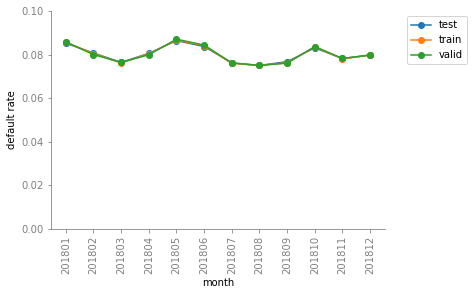

In [12]:
default_rate_in_time_per_sample(data, col_target, col_month, 'sample')

## Define Sample Masks

In [13]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test') 
oot_mask = (data['sample'] == 'oot')  
hoot_mask = (data['sample'] == 'hoot')

# Data preprocessing

## Replace infinity

In [14]:
# find columns with infinity values
cols_with_inf = []
for col in cols_pred_num:
    if np.any(np.isinf(data[col])):
        cols_with_inf.append(col)
        print(f'Column {col} includes infinity values.')

# find columns with negative infinity values
cols_with_neginf = []
for col in cols_pred_num:
    if np.any(np.isneginf(data[col])):
        cols_with_neginf.append(col)
        print(f'Column {col} includes negative infinity values.')

Column MEAN_AMTCR_1M_3M_DIV_MEAN_AMTCR_3M_12M includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_1M_3M_TYPE_EQ_CLOSED_DIV_MEAN_AMTCR_3M_12M_TYPE_EQ_CLOSED includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_DIV_MEAN_AMTCR_0M_INFM includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_DIV_MEAN_AMTCR_0M_12M includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_INFM_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_INFM_TYPE_EQ_ACTIVE includes infinity values.
Column MEAN_AMTCR_OVERDUE_0M_12M_TYPE_EQ_ACTIVE_DIV_MEAN_AMTCR_0M_12M_TYPE_EQ_ACTIVE includes infinity values.


In [15]:
# replace infinity values
for col in cols_with_inf:
    data[col].replace(np.inf, 9999999, inplace = True)

## Encode Categorical Predictors
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot DR_{category} + \alpha \cdot DR}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $DR_{category}$ default rate in this category and $DR$ is total default rate.

<span style="color:red">**TO DO:** Define function for mean target encoding.</span>

Function should have following input parameters:
- data ... pd.DataFrame with data to be used for MTE calculation
- predictor ... name of the predictor to be encoded
- target ... name of the target column
- alpha ... viz equation in previous cell

It should output a dictionary where each key stands for one category and corresponding value is MTE. Example:

{
  'category 1': 0.0758621,
  'category 2': 0.8635423,
  ...
}

In [16]:
# from category_encoding import mean_target_encoding

In [17]:
# total_dr = np.mean(data[train_mask][col_target])

# # encode categorical predictors
# for pred in tqdm(cols_pred_cat):
#     if len(data[pred].unique()) < 0:
#         dummies = pd.get_dummies(
#             data[pred], 
#             prefix = pred,
#             prefix_sep = '_',
#             dummy_na = True if data[pred].isnull().sum() > 0 else False,
#             drop_first = False
#         )
        
#         for d in dummies.columns:
#             if d in data.columns:
#                 del data[d]
                
#         data = data.join(dummies)
        
#         for col in dummies.columns:
#             if col not in cols_pred:
#                 cols_pred.append(col)
        
#         if pred in cols_pred:
#             cols_pred.remove(pred)
#     else:
#         new_vals = mean_target_encoding(
#             dt=data[train_mask], 
#             predictor=pred, 
#             target=col_target
#         )

#         additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
#         for p in additional_values:
#             new_vals[p] = total_dr

#         data['MTE_' + pred] = data[pred].replace(new_vals)
        
#         if 'MTE_' + pred not in cols_pred:
#             cols_pred.append('MTE_' + pred)
        
#         if pred in cols_pred:
#             cols_pred.remove(pred)

In [18]:
# REMOVE
for p in [ 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'
          , 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS'
          , 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'
          , 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']:
    
    print(p)
    cols_pred.remove(p)
    

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE
FONDKAPREMONT_MODE
HOUSETYPE_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE


# XGBoost model
- XGBoost model is provided in package `xgboost`

## First XGBoost model
- **early stopping:** Model is trained on training sample and we control model performance on evaluation sample (can be valid or test). If the model does not improve after *n* iterations, we stop the training.
- Data must be passed to training as *xgb.DMatrix* data type.
- Parameter *dtrain* defines data set to be used for training. Parameter evals is used for passing evaluation data sets - eval_metric will be evaluated on those sets in each iteration. Last data set from evals is used for early stopping.

In [19]:
# set best parameters to be used in XGBoost
params = {    
#     'max_depth': 2,
    
    'objective': 'binary:logistic',
    'eval_metric': ['auc'],
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.71588	test-auc:0.69547	valid-auc:0.70288
[1]	train-auc:0.73195	test-auc:0.69823	valid-auc:0.71254
[2]	train-auc:0.73971	test-auc:0.70149	valid-auc:0.71840
[3]	train-auc:0.74936	test-auc:0.70360	valid-auc:0.72236
[4]	train-auc:0.75605	test-auc:0.70314	valid-auc:0.72210
[5]	train-auc:0.76439	test-auc:0.70313	valid-auc:0.72586
[6]	train-auc:0.77148	test-auc:0.70413	valid-auc:0.72613
[7]	train-auc:0.77936	test-auc:0.70588	valid-auc:0.72767
[8]	train-auc:0.78852	test-auc:0.70653	valid-auc:0.73060
[9]	train-auc:0.79484	test-auc:0.70769	valid-auc:0.73215
[10]	train-auc:0.80065	test-auc:0.70977	valid-auc:0.73281
[11]	train-auc:0.80654	test-auc:0.70838	valid-auc:0.73400
[12]	train-auc:0.81188	test-auc:0.71069	valid-auc:0.73642
[13]	train-auc:0.82019	test-auc:0.71205	valid-auc:0.73908
[14]	train-auc:0.82487	test-auc:0.71227	valid-auc:0.73960
[15]	train-auc:0.82990	test-auc:0.71279	valid-auc:0.74039
[16]	train-auc:0.83388	test-auc:0.71395	valid-auc:0.74127
[17]	train-auc:0.83881	t

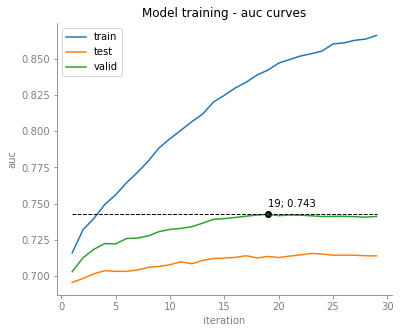

In [20]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.savefig('test.svg', format='svg')
# plt.close()

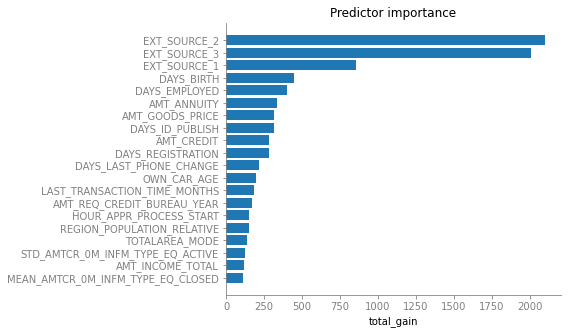

In [21]:
importance_type = 'total_gain'

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 20
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:20])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:20])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

## XGBoost in sklearn

In [27]:
booster_sklearn = xgb.XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    random_state=12,
    verbosity=1,
    eval_metric='auc',
    use_label_encoder=False,    
)

booster_sklearn.fit(
    data[train_mask][cols_pred].values, 
    data[train_mask][col_target].astype(int).values,
    eval_set=[
        (data[train_mask][cols_pred].values, data[train_mask][col_target].values),
        (data[test_mask][cols_pred].values, data[test_mask][col_target].values),
        (data[valid_mask][cols_pred].values, data[valid_mask][col_target].values),
    ],
    verbose=True,
    early_stopping_rounds=10
)

[0]	validation_0-auc:0.71588	validation_1-auc:0.69547	validation_2-auc:0.70288
[1]	validation_0-auc:0.73195	validation_1-auc:0.69823	validation_2-auc:0.71254
[2]	validation_0-auc:0.73971	validation_1-auc:0.70149	validation_2-auc:0.71840
[3]	validation_0-auc:0.74936	validation_1-auc:0.70360	validation_2-auc:0.72236
[4]	validation_0-auc:0.75605	validation_1-auc:0.70314	validation_2-auc:0.72210
[5]	validation_0-auc:0.76439	validation_1-auc:0.70313	validation_2-auc:0.72586
[6]	validation_0-auc:0.77148	validation_1-auc:0.70413	validation_2-auc:0.72613
[7]	validation_0-auc:0.77936	validation_1-auc:0.70588	validation_2-auc:0.72767
[8]	validation_0-auc:0.78852	validation_1-auc:0.70653	validation_2-auc:0.73060
[9]	validation_0-auc:0.79484	validation_1-auc:0.70769	validation_2-auc:0.73215
[10]	validation_0-auc:0.80065	validation_1-auc:0.70977	validation_2-auc:0.73281
[11]	validation_0-auc:0.80654	validation_1-auc:0.70838	validation_2-auc:0.73400
[12]	validation_0-auc:0.81188	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=12,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

## Final model
Befor fitting final model, selection of optimal predictors might be considered. A model withthe similar performance can be fitted using *n* strongest predictors or using all available predictors. Sometime implementation of the predictors into the production might take some time and therefore you prefer to have "reasonable" number of predictors in your model. On the contrary, having larger number of predictors might bring better robustness - if one of the predictors would broke, the impact for the model would be lower.

For selection of optimal predictors, similar approach as forward (or backward) process can be used.

### Cross validation score

In [23]:
params={
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

skf = StratifiedKFold(n_splits = 2, shuffle = True, random_state = 12)

X = data[cols_pred].values
y = data[col_target].values
data['cv_score'] = -1
cv_res = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    evals_result = {}
    booster = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(X_train, y_train),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(X_train, y_train), 'train'),
            (xgb.DMatrix(X_test, y_test), 'test'),
        ),
        evals_result = evals_result,
        early_stopping_rounds = 10,
        verbose_eval = True
    )
    
    gini_train = 2 * roc_auc_score(y_train, booster.predict(xgb.DMatrix(X_train))) - 1
    gini_test  = 2 * roc_auc_score(y_test,  booster.predict(xgb.DMatrix(X_test)))  - 1
    best_iteration = booster.best_iteration
    
    cv_res += [(gini_train, gini_test, best_iteration)]
    
    data.iloc[test_index, list(data.columns).index('cv_score')] = list(booster.predict(xgb.DMatrix(X_test), iteration_range=(0, booster.best_iteration)))

[0]	train-auc:0.59839	test-auc:0.58256
[1]	train-auc:0.68163	test-auc:0.67393
[2]	train-auc:0.68336	test-auc:0.67945
[3]	train-auc:0.71208	test-auc:0.70276
[4]	train-auc:0.71692	test-auc:0.70787
[5]	train-auc:0.71920	test-auc:0.70965
[6]	train-auc:0.72221	test-auc:0.71033
[7]	train-auc:0.72778	test-auc:0.71313
[8]	train-auc:0.72942	test-auc:0.71414
[9]	train-auc:0.72881	test-auc:0.71437
[10]	train-auc:0.72882	test-auc:0.71524
[11]	train-auc:0.72799	test-auc:0.71437
[12]	train-auc:0.72727	test-auc:0.71468
[13]	train-auc:0.72704	test-auc:0.71458
[14]	train-auc:0.72687	test-auc:0.71528
[15]	train-auc:0.72815	test-auc:0.71644
[16]	train-auc:0.72903	test-auc:0.71645
[17]	train-auc:0.72931	test-auc:0.71663
[18]	train-auc:0.72921	test-auc:0.71582
[19]	train-auc:0.73017	test-auc:0.71716
[20]	train-auc:0.73178	test-auc:0.71857
[21]	train-auc:0.73187	test-auc:0.71840
[22]	train-auc:0.73270	test-auc:0.71861
[23]	train-auc:0.73303	test-auc:0.71860
[24]	train-auc:0.73328	test-auc:0.71842
[25]	train

[107]	train-auc:0.78185	test-auc:0.73787
[108]	train-auc:0.78216	test-auc:0.73796
[109]	train-auc:0.78261	test-auc:0.73790
[110]	train-auc:0.78293	test-auc:0.73812
[111]	train-auc:0.78333	test-auc:0.73828
[112]	train-auc:0.78359	test-auc:0.73850
[113]	train-auc:0.78392	test-auc:0.73854
[114]	train-auc:0.78419	test-auc:0.73852
[115]	train-auc:0.78472	test-auc:0.73874
[116]	train-auc:0.78519	test-auc:0.73865
[117]	train-auc:0.78551	test-auc:0.73867
[118]	train-auc:0.78557	test-auc:0.73875
[119]	train-auc:0.78571	test-auc:0.73875
[120]	train-auc:0.78608	test-auc:0.73873
[121]	train-auc:0.78646	test-auc:0.73863
[122]	train-auc:0.78674	test-auc:0.73841
[123]	train-auc:0.78716	test-auc:0.73848
[124]	train-auc:0.78765	test-auc:0.73859
[125]	train-auc:0.78818	test-auc:0.73850
[126]	train-auc:0.78852	test-auc:0.73868
[127]	train-auc:0.78859	test-auc:0.73872
[128]	train-auc:0.78919	test-auc:0.73878
[129]	train-auc:0.78966	test-auc:0.73871
[130]	train-auc:0.78990	test-auc:0.73881
[131]	train-auc:

In [24]:
# Performance during cross validation
cv_res

[(0.5658947834534125, 0.4726515922359791, 88),
 (0.5940252465297942, 0.47786301803655706, 145)]

In [25]:
gini_cv = 2 * roc_auc_score(data[col_target], data['cv_score']) - 1
print(f'Cross validation score performance: {gini_cv:.4f}')

Cross validation score performance: 0.4755


In [26]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = 130,
    evals_result = evals_result
)

[0]	train-auc:0.59644
[1]	train-auc:0.67799
[2]	train-auc:0.71122
[3]	train-auc:0.71337
[4]	train-auc:0.71687
[5]	train-auc:0.71535
[6]	train-auc:0.71585
[7]	train-auc:0.71674
[8]	train-auc:0.71877
[9]	train-auc:0.71911
[10]	train-auc:0.71925
[11]	train-auc:0.72029
[12]	train-auc:0.72111
[13]	train-auc:0.72087
[14]	train-auc:0.72243
[15]	train-auc:0.72259
[16]	train-auc:0.72287
[17]	train-auc:0.72410
[18]	train-auc:0.72433
[19]	train-auc:0.72486
[20]	train-auc:0.72720
[21]	train-auc:0.72968
[22]	train-auc:0.73002
[23]	train-auc:0.72968
[24]	train-auc:0.73027
[25]	train-auc:0.73016
[26]	train-auc:0.72999
[27]	train-auc:0.73028
[28]	train-auc:0.73120
[29]	train-auc:0.73172
[30]	train-auc:0.73178
[31]	train-auc:0.73186
[32]	train-auc:0.73338
[33]	train-auc:0.73443
[34]	train-auc:0.73470
[35]	train-auc:0.73516
[36]	train-auc:0.73570
[37]	train-auc:0.73625
[38]	train-auc:0.73762
[39]	train-auc:0.73809
[40]	train-auc:0.73937
[41]	train-auc:0.73974
[42]	train-auc:0.74097
[43]	train-auc:0.7415

In [27]:
gini_train = 2 * roc_auc_score(data[col_target], booster.predict(xgb.DMatrix(data[cols_pred]))) - 1
print(gini_train)

0.5407289013922847


### Final model using splitted data

In [28]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,

    'eval_metric': ['logloss', 'auc'],
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12,
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 300,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-logloss:0.62581	train-auc:0.60096	test-logloss:0.62594	test-auc:0.58312	valid-logloss:0.62586	valid-auc:0.59767
[1]	train-logloss:0.56984	train-auc:0.69199	test-logloss:0.57001	test-auc:0.67660	valid-logloss:0.56987	valid-auc:0.68771
[2]	train-logloss:0.52371	train-auc:0.71130	test-logloss:0.52405	test-auc:0.69298	valid-logloss:0.52374	valid-auc:0.71088
[3]	train-logloss:0.48525	train-auc:0.71588	test-logloss:0.48590	test-auc:0.69485	valid-logloss:0.48528	valid-auc:0.71834
[4]	train-logloss:0.45289	train-auc:0.71335	test-logloss:0.45377	test-auc:0.69020	valid-logloss:0.45288	valid-auc:0.71680
[5]	train-logloss:0.42509	train-auc:0.71668	test-logloss:0.42599	test-auc:0.69603	valid-logloss:0.42509	valid-auc:0.71903
[6]	train-logloss:0.40135	train-auc:0.71966	test-logloss:0.40240	test-auc:0.69949	valid-logloss:0.40135	valid-auc:0.72125
[7]	train-logloss:0.38125	train-auc:0.71900	test-logloss:0.38253	test-auc:0.69754	valid-logloss:0.38129	valid-auc:0.72125
[8]	train-logloss:0.3640

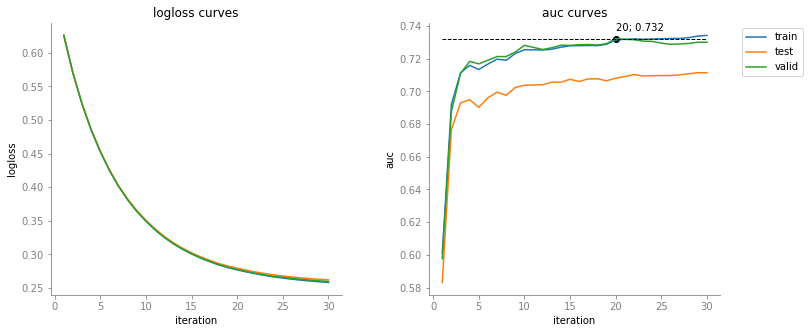

In [29]:
metric = 'logloss'

fig, axs = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace=0.3)

total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    axs[0].plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

    
for sample, vals in evals_result.items():
    axs[1].plot(
        range(1, total_iteration_count + 1), 
        vals['auc'],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('logloss')
axs[0].set_title(f'logloss curves')

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_color('gray')
axs[0].spines['bottom'].set_color('gray')
axs[0].tick_params(axis='y', colors='gray')
axs[0].tick_params(axis='x', colors='gray')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('auc')
axs[1].set_title(f'auc curves')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_color('gray')
axs[1].spines['bottom'].set_color('gray')
axs[1].tick_params(axis='y', colors='gray')
axs[1].tick_params(axis='x', colors='gray')

plt.legend(loc='upper right',  bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

plt.show()

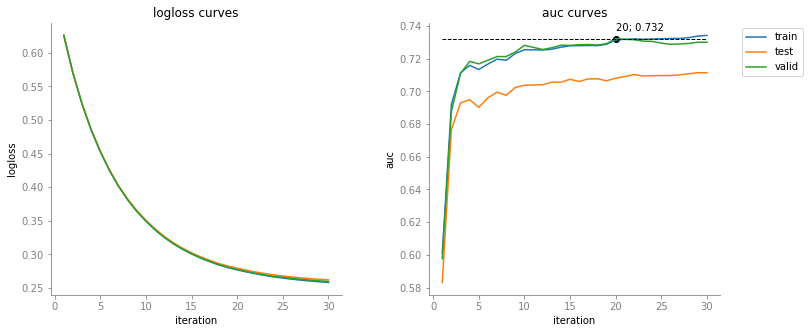

In [30]:
metric = 'logloss'

fig, axs = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace=0.3)

total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    axs[0].plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

    
for sample, vals in evals_result.items():
    axs[1].plot(
        range(1, total_iteration_count + 1), 
        vals['auc'],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('logloss')
axs[0].set_title(f'logloss curves')

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].spines['left'].set_color('gray')
axs[0].spines['bottom'].set_color('gray')
axs[0].tick_params(axis='y', colors='gray')
axs[0].tick_params(axis='x', colors='gray')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('auc')
axs[1].set_title(f'auc curves')

axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].spines['left'].set_color('gray')
axs[1].spines['bottom'].set_color('gray')
axs[1].tick_params(axis='y', colors='gray')
axs[1].tick_params(axis='x', colors='gray')

plt.legend(loc='upper right',  bbox_to_anchor=(0.8, 0.5, 0.5, 0.5))

plt.show()

#### Applying monotone constraints

In [31]:
positive_monotone_constraint = [
]

negative_monotone_constraint = [
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]

constr = []
for col in cols_pred:
    if col in positive_monotone_constraint:
        constr.append('1')
    elif col in negative_monotone_constraint:
        constr.append('-1')
    else:
        constr.append('0')

constr = '(' + ','.join(constr) + ')'
constr

'(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)'

In [32]:
# Final model
params = {    
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'monotone_constraints': constr,
    
    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'tree_method': 'exact',

    'seed': 12
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred],  data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid')
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10,
    verbose_eval = True
)

[0]	train-auc:0.60153	test-auc:0.58626	valid-auc:0.59913
[1]	train-auc:0.69959	test-auc:0.68407	valid-auc:0.70081
[2]	train-auc:0.71132	test-auc:0.69724	valid-auc:0.71052
[3]	train-auc:0.71552	test-auc:0.69767	valid-auc:0.71752
[4]	train-auc:0.71540	test-auc:0.69586	valid-auc:0.71767
[5]	train-auc:0.71767	test-auc:0.70054	valid-auc:0.71922
[6]	train-auc:0.71792	test-auc:0.70025	valid-auc:0.71870
[7]	train-auc:0.71725	test-auc:0.69823	valid-auc:0.71803
[8]	train-auc:0.72123	test-auc:0.70333	valid-auc:0.72130
[9]	train-auc:0.72396	test-auc:0.70565	valid-auc:0.72624
[10]	train-auc:0.72313	test-auc:0.70534	valid-auc:0.72419
[11]	train-auc:0.72224	test-auc:0.70395	valid-auc:0.72290
[12]	train-auc:0.72398	test-auc:0.70646	valid-auc:0.72397
[13]	train-auc:0.72458	test-auc:0.70568	valid-auc:0.72488
[14]	train-auc:0.72593	test-auc:0.70812	valid-auc:0.72500
[15]	train-auc:0.72594	test-auc:0.70715	valid-auc:0.72531
[16]	train-auc:0.72641	test-auc:0.70924	valid-auc:0.72567
[17]	train-auc:0.72582	t

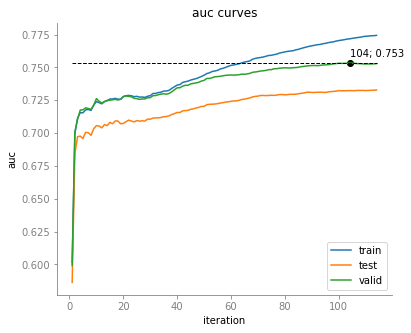

In [33]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    plt.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

plt.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
plt.scatter([best_iteration], [best_score], color = 'black')
plt.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
#     textcoords = 'offset points'
)
plt.xlabel('iteration')
plt.ylabel(metric)
plt.legend(loc='best')
plt.title(f'{metric} curves')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

# Model validation

In [20]:
data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,booster.best_iteration))
data['predicted_score'] = np.log(data['predicted_pd'] / (1 - data['predicted_pd']))

## Plot individual trees

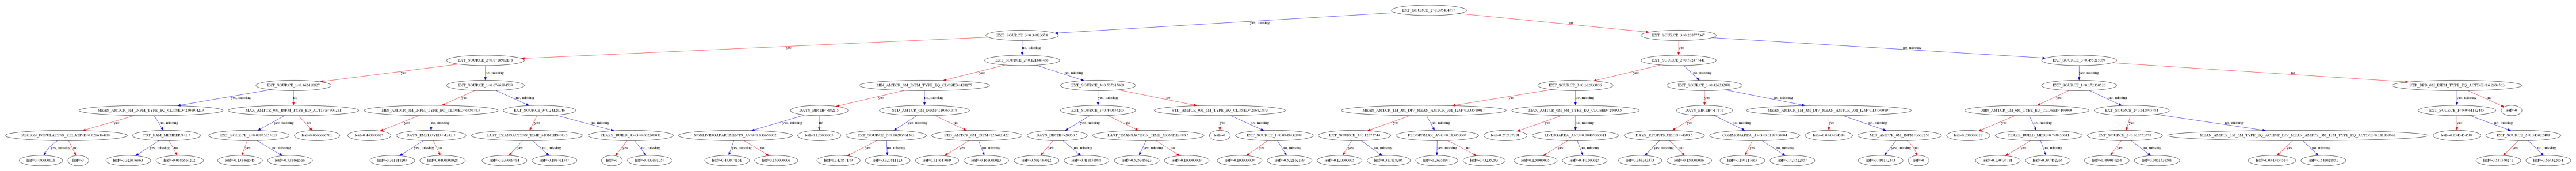

In [21]:
# might need python-graphviz == 0.16
from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 80,50

plot_tree(booster, num_trees = 0)
plt.show()

rcParams['figure.figsize'] = 5,5

## Score distribution

In [22]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin').agg(
        bad_cnt = (col_target, sum),
        tot_cnt = (col_target, len),
        def_rt = (col_target, np.mean),
        avg_score = (col_score, np.mean)
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

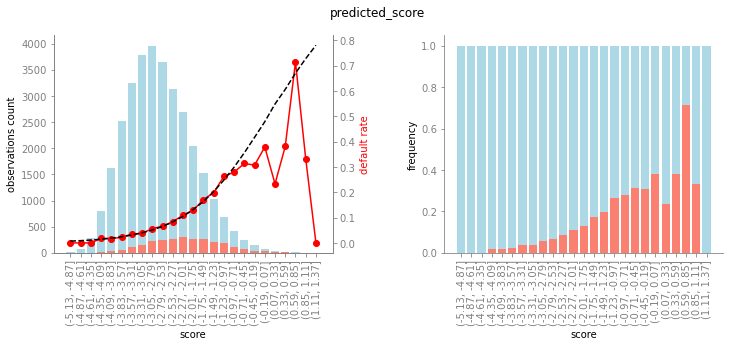

In [23]:
plot_score_calibration(data[valid_mask | test_mask], 'predicted_score', col_target)

## Permutation importance
- Let's have dataset $D$ and model with score (AUC for instance) $s$
- For each feature $j$ calculate permutation importance as follows:
    - for $k$ in $1,\ldots,K$:
        - shuffle column $j$ in dataset $D$ -> $\hat{D}_{k,j}$
        - compute the score $s_{k,j}$ using $\hat{D}_{k,j}$
    - importance $i_j$ for feature $f_j$ is defined as:
$$i_j = s - \frac{1}{K}\sum_{k=1}^K s_{k,j}$$

In [24]:
from sklearn.inspection import permutation_importance

In [31]:
# for sklearn, there is a function
r = permutation_importance(booster_sklearn, data[test_mask][cols_pred], data[test_mask][col_target], n_repeats=5, random_state=0)

In [59]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{cols_pred[i]:<8}    "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

EXT_SOURCE_3    0.000 +/- 0.000
REGION_RATING_CLIENT_W_CITY    0.000 +/- 0.000
AMT_CREDIT    0.000 +/- 0.000
MEDIAN_AMTCR_0M_INFM    0.000 +/- 0.000
MIN_AMTCR_0M_6M    0.000 +/- 0.000
STD_AMTCR_0M_INFM_TYPE_EQ_CLOSED    0.000 +/- 0.000


In [33]:
def permutation_importance(dt, predictor, target, model, n_iters = 10):
    predictors = list(dt.columns)
    predictors.remove(target)
    
    prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
    s = roc_auc_score(dt[target], prediction)
    
    sk = []
    for i in range(n_iters):
        x = dt[predictor].to_list()
        np.random.shuffle(x)
        dt[predictor] = x
        prediction = model.predict(xgb.DMatrix(dt[predictors]), iteration_range=(0,model.best_iteration))
        sk.append(roc_auc_score(dt[target], prediction))
    
    sk_mean = np.mean(sk)
    sk_perc05 = np.percentile(sk, q=5)
    sk_perc95 = np.percentile(sk, q=95)
    
    return s - sk_mean, s - sk_perc05, s - sk_perc95    

In [34]:
res = []
for pred in tqdm(cols_pred[0:10]):
    pi, iqr95, iqr05 = permutation_importance(
        dt=data[test_mask][cols_pred + [col_target]], 
        predictor=pred,
        target=col_target,
        model=booster,
        n_iters=10
    )
    res.append((pred, pi, iqr05, iqr95))
res = pd.DataFrame(res, columns = ['predictor', 'permutation_importance', 'iqr05', 'iqr95'])
res

  0%|          | 0/10 [00:00<?, ?it/s]

,predictor,permutation_importance,iqr05,iqr95
0,CNT_CHILDREN,0.000542,0.000154,0.000922
1,AMT_INCOME_TOTAL,-0.000352,-0.000866,0.000174
2,AMT_CREDIT,0.003224,0.001950,0.004393
3,AMT_ANNUITY,0.002385,0.000132,0.004130
4,AMT_GOODS_PRICE,0.008263,0.006073,0.011491
5,REGION_POPULATION_RELATIVE,0.000309,-0.000348,0.001100
6,DAYS_BIRTH,0.001892,0.000250,0.003300
7,DAYS_EMPLOYED,0.007912,0.006557,0.008751
8,DAYS_REGISTRATION,-0.000186,-0.001555,0.001015
9,DAYS_ID_PUBLISH,-0.001274,-0.002029,-0.000417


## Marginal contribution

In [60]:
def fit_model(predictors):
    params={
        'eta': 0.2,
        'max_depth': 3,

        'eval_metric': 'auc',
        'objective': 'binary:logistic' ,
        'booster': 'gbtree',
        'tree_method': 'hist',

        'base_score': 0.08,

        'seed': 12
    }

    evals_result = {}

    booster_mc = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 20
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction = booster.predict(xgb.DMatrix(data[test_mask][cols_pred]), iteration_range=(0,booster.best_iteration))
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred[0:5]):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))

  0%|          | 0/5 [00:00<?, ?it/s]

[0]	train-auc:0.68498	test-auc:0.67371	valid-auc:0.68337
[1]	train-auc:0.70512	test-auc:0.68686	valid-auc:0.70749
[2]	train-auc:0.71304	test-auc:0.69663	valid-auc:0.71198
[3]	train-auc:0.71632	test-auc:0.69772	valid-auc:0.71665
[4]	train-auc:0.71961	test-auc:0.69873	valid-auc:0.71885
[5]	train-auc:0.72349	test-auc:0.70407	valid-auc:0.72276
[6]	train-auc:0.72654	test-auc:0.70447	valid-auc:0.72555
[7]	train-auc:0.72954	test-auc:0.70627	valid-auc:0.72625
[8]	train-auc:0.73135	test-auc:0.70746	valid-auc:0.72786
[9]	train-auc:0.73462	test-auc:0.70986	valid-auc:0.73094
[10]	train-auc:0.73707	test-auc:0.71196	valid-auc:0.73421
[11]	train-auc:0.73892	test-auc:0.71377	valid-auc:0.73502
[12]	train-auc:0.74083	test-auc:0.71492	valid-auc:0.73565
[13]	train-auc:0.74315	test-auc:0.71783	valid-auc:0.73777
[14]	train-auc:0.74617	test-auc:0.71943	valid-auc:0.73945
[15]	train-auc:0.74792	test-auc:0.72082	valid-auc:0.74048
[16]	train-auc:0.74948	test-auc:0.72241	valid-auc:0.74200
[17]	train-auc:0.75031	t

[61]	train-auc:0.78358	test-auc:0.72793	valid-auc:0.75163
[62]	train-auc:0.78431	test-auc:0.72871	valid-auc:0.75201
[63]	train-auc:0.78465	test-auc:0.72868	valid-auc:0.75222
[64]	train-auc:0.78531	test-auc:0.72856	valid-auc:0.75235
[65]	train-auc:0.78559	test-auc:0.72855	valid-auc:0.75244
[66]	train-auc:0.78603	test-auc:0.72860	valid-auc:0.75237
[67]	train-auc:0.78653	test-auc:0.72834	valid-auc:0.75227
[68]	train-auc:0.78689	test-auc:0.72851	valid-auc:0.75226
[69]	train-auc:0.78772	test-auc:0.72854	valid-auc:0.75222
[70]	train-auc:0.78818	test-auc:0.72851	valid-auc:0.75228
[71]	train-auc:0.78829	test-auc:0.72851	valid-auc:0.75243
[72]	train-auc:0.78892	test-auc:0.72834	valid-auc:0.75201
[73]	train-auc:0.78917	test-auc:0.72833	valid-auc:0.75182
[74]	train-auc:0.78933	test-auc:0.72827	valid-auc:0.75148
[75]	train-auc:0.78962	test-auc:0.72824	valid-auc:0.75123
[76]	train-auc:0.79023	test-auc:0.72836	valid-auc:0.75103
[77]	train-auc:0.79079	test-auc:0.72846	valid-auc:0.75115
[78]	train-auc

[32]	train-auc:0.76463	test-auc:0.72775	valid-auc:0.74623
[33]	train-auc:0.76547	test-auc:0.72757	valid-auc:0.74617
[34]	train-auc:0.76588	test-auc:0.72760	valid-auc:0.74641
[35]	train-auc:0.76709	test-auc:0.72821	valid-auc:0.74632
[36]	train-auc:0.76764	test-auc:0.72875	valid-auc:0.74654
[37]	train-auc:0.76813	test-auc:0.72873	valid-auc:0.74672
[38]	train-auc:0.76966	test-auc:0.72902	valid-auc:0.74762
[39]	train-auc:0.77046	test-auc:0.72886	valid-auc:0.74845
[40]	train-auc:0.77142	test-auc:0.72922	valid-auc:0.74869
[41]	train-auc:0.77203	test-auc:0.72907	valid-auc:0.74875
[42]	train-auc:0.77260	test-auc:0.72925	valid-auc:0.74898
[43]	train-auc:0.77294	test-auc:0.72949	valid-auc:0.74900
[44]	train-auc:0.77360	test-auc:0.72940	valid-auc:0.74928
[45]	train-auc:0.77403	test-auc:0.72962	valid-auc:0.74934
[46]	train-auc:0.77469	test-auc:0.73053	valid-auc:0.74960
[47]	train-auc:0.77556	test-auc:0.73040	valid-auc:0.74966
[48]	train-auc:0.77612	test-auc:0.73019	valid-auc:0.74967
[49]	train-auc

In [61]:
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)

In [62]:
marginal_contribution

[('AMT_ANNUITY', -0.019955210042034488),
 ('AMT_CREDIT', -0.019005094346647433),
 ('CNT_CHILDREN', -0.017903378529853242),
 ('AMT_INCOME_TOTAL', -0.016625886013338365),
 ('AMT_GOODS_PRICE', -0.015164116598155752)]

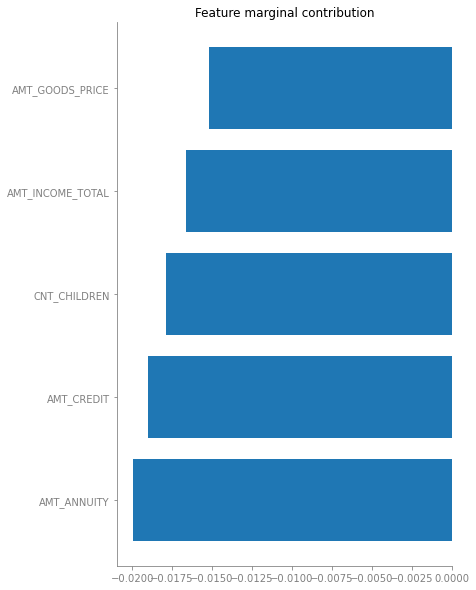

In [63]:
# feature_perm_importance = sorted(zip(cols_pred, pi['importances_mean']), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

## PDP plots
- PDP = Partial Dependence Plot

In [64]:
def partial_dependency(bst, X, y, feature_names, feature_ids = [], f_id = -1):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """
    X_temp = X.copy()
    grid = np.linspace(
        np.percentile(X_temp[:, f_id], 0.1),
        np.percentile(X_temp[:, f_id], 99.5),
        50
    )
    y_pred = np.zeros(len(grid))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp[:, f_id] = val
            data = xgb.DMatrix(X_temp, feature_names = feature_names)

            y_pred[i] = np.average(bst.predict(data))

    return grid, y_pred

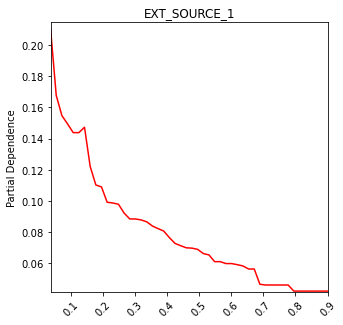

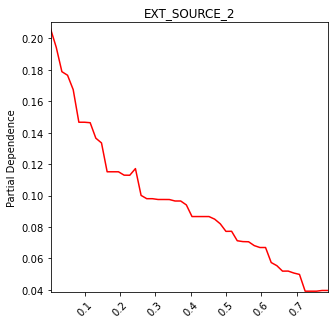

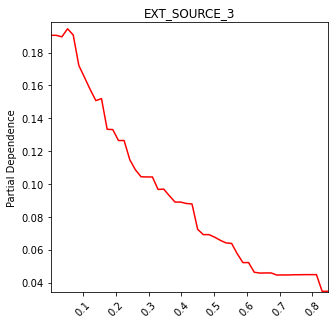

In [65]:
lst_f = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
# cols_pred
sampled_data = data.sample(frac=0.1, random_state=22)
for f in lst_f:
    f_id = cols_pred.index(f)
    feature_ids = range(len(cols_pred))

    mask = sampled_data[f].notnull()
    grid, y_pred = partial_dependency(
        booster,
        sampled_data[mask][cols_pred].values,
        sampled_data[mask][col_target].values,
        feature_names = cols_pred,
        feature_ids = feature_ids,
        f_id = f_id
    )

    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    plt.subplots_adjust(left = 0.17, right = 0.94, bottom = 0.15, top = 0.9)

    ax.plot(grid, y_pred, ls = '-', color = 'red', linewidth = 1.5, label='fit')

    ax.set_xlim(min(grid), max(grid))
    ax.set_ylim(0.98 * min(y_pred), 1.02 * max(y_pred))

    ax.set_title(f)
    ax.set_ylabel('Partial Dependence')
    plt.xticks(rotation=45)

    plt.show()

## ICE plots
- ICE = Individual Conditional Expectation

In [67]:
def ice_data(bst, dt, predictor, n_points=20):
    X = dt.copy()
    grid = np.linspace(
        dt[predictor].quantile(0.01),
        dt[predictor].quantile(0.99),
        n_points
    )
    
    y_pred = np.zeros((len(dt), len(grid)))

    if len(feature_ids) == 0 or f_id == -1:
        print ('Input error!')
        return
    else:
        for i, val in enumerate(grid):
            X[predictor] = val
            data = xgb.DMatrix(X, feature_names = X.columns)

            y_pred[:,i] = bst.predict(data)
    return grid, y_pred

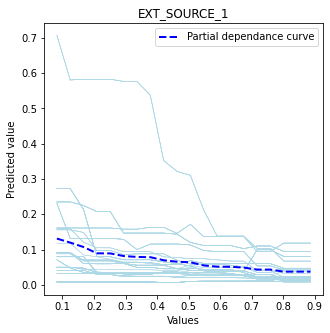

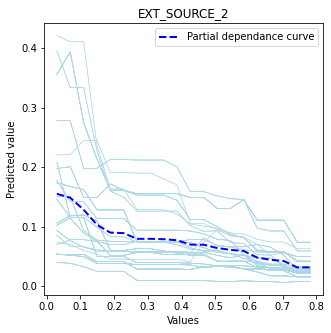

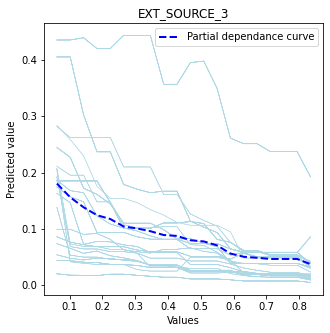

In [68]:
n_plots = 100
cols_to_plot = ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']

sampled_data = data.sample(n=10000, random_state=22)

for pred in cols_to_plot:
    x, ice_data_plot = ice_data(booster, sampled_data[cols_pred], pred)

    idx = np.random.randint(len(x), size=n_plots)
    plt.plot(x, np.transpose(ice_data_plot[idx,:]), lw = 0.5, color = 'lightblue')
    plt.plot(x, np.average(ice_data_plot[idx,:], axis = 0), lw = 2, ls = '--', color = 'blue', label = 'Partial dependance curve')
    plt.title(pred)
    plt.ylabel('Predicted value')
    plt.xlabel('Values')
    plt.legend(loc='best')
    plt.show()

## SHAP
- SHAP = SHapley Additive exPlanations
- Original paper presenting SHAP values can be downloaded here: <a href=https://arxiv.org/abs/1705.07874 target="_blank">SHAP values</a>
- SHAP values are defined by following equation:
$$ \phi_i = \sum_{S\subseteq F\setminus\lbrace i \rbrace} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \lbrace i\rbrace}(x_{S\cup \lbrace i\rbrace})-f_S(x_S)] $$
where:

    - $F$ ... set of all model features
    - $S$ ... $S \subseteq F \setminus\lbrace i\rbrace$
    - $\phi_i$ ... SAHP value for predictor $x_i$
    - $f_S(x_S)$ ... output of model build on feature set $S$ given feature values $x_S$

In [69]:
import shap
shap.initjs()

In [70]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[cols_pred])

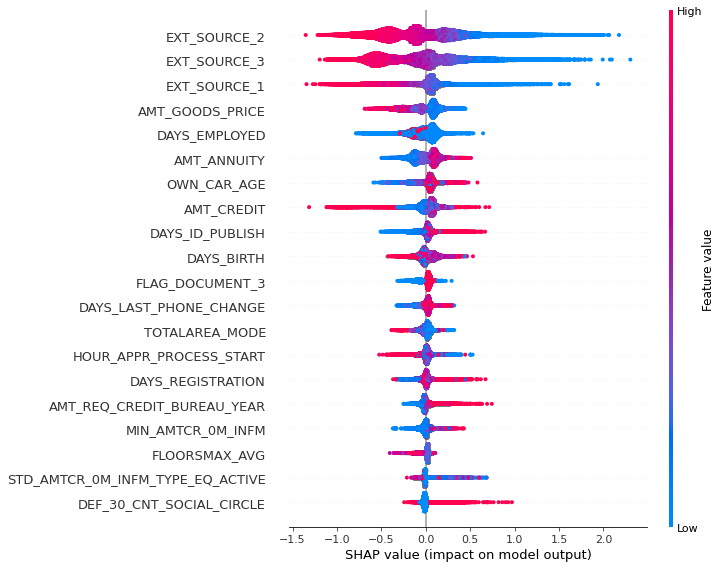

In [71]:
plt.figure()
shap.summary_plot(shap_values, data[cols_pred], max_display=20, show=True)
plt.show()

In [72]:
shap.force_plot(explainer.expected_value, shap_values[0,:], data[cols_pred].iloc[0,:])

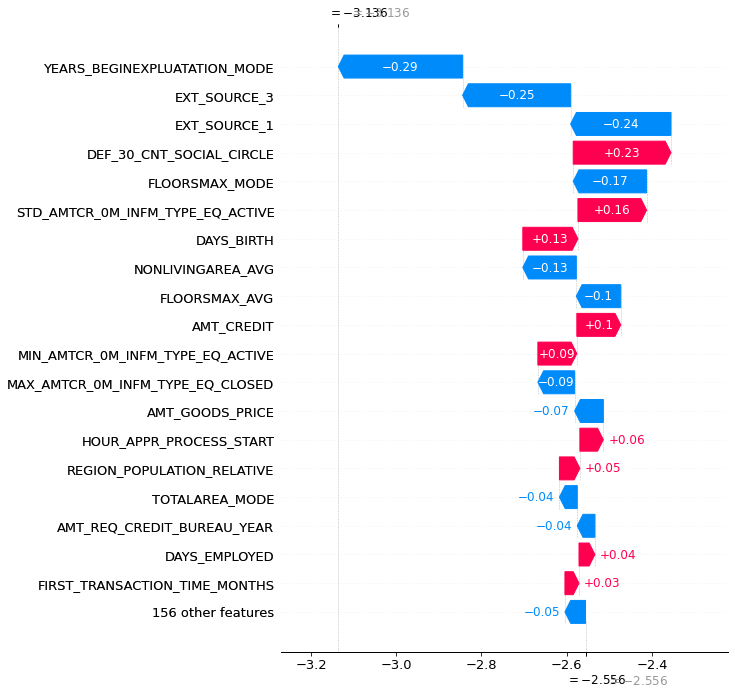

In [73]:
shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value, 
    shap_values=shap_values[0, :], 
    feature_names=cols_pred, 
    max_display=20
)

### SHAP interaction values

In [77]:
Xd = xgb.DMatrix(data[train_mask][cols_pred].iloc[:1000], data[train_mask][col_target].iloc[:1000])

explainer = shap.TreeExplainer(booster)
shap_interaction_values = explainer.shap_interaction_values(Xd)

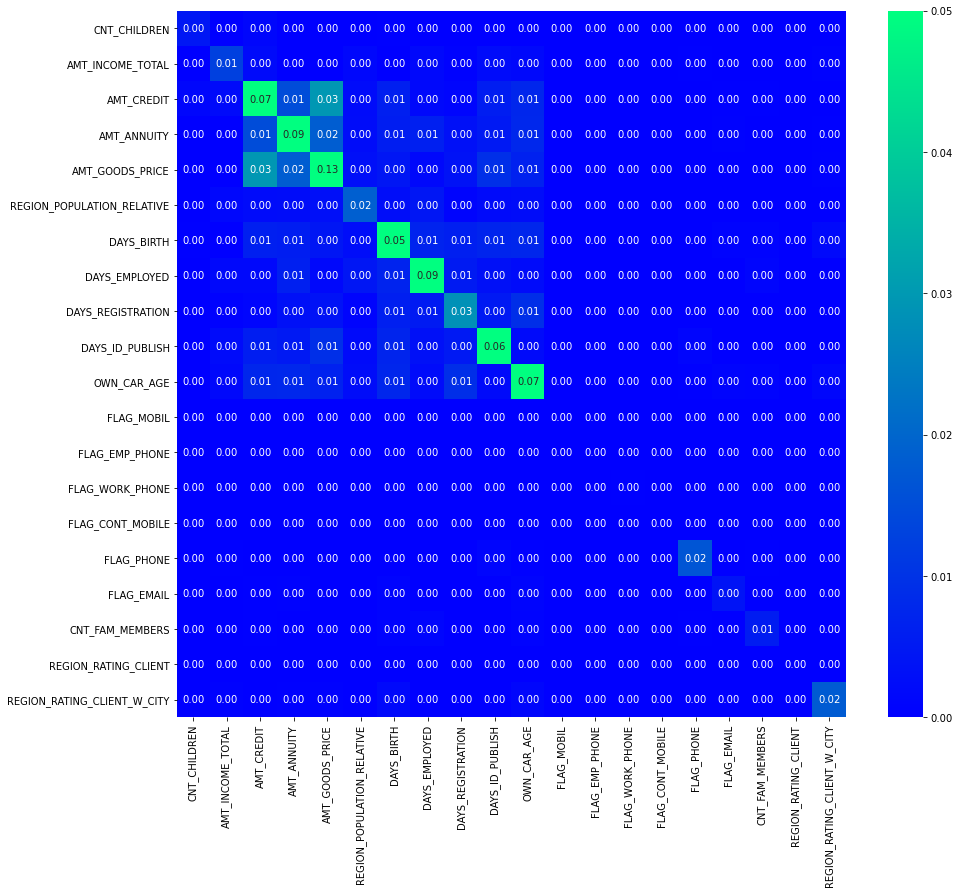

In [78]:
plt.figure(figsize=(15,13))

sns.heatmap(
    data=np.mean(abs(shap_interaction_values[:, 0:20, 0:20]), axis=0), 
    annot=True, 
    fmt='.2f', 
    xticklabels=cols_pred[0:20], 
    yticklabels=cols_pred[0:20],
    cmap='winter',
    vmax=0.05
)

plt.show()

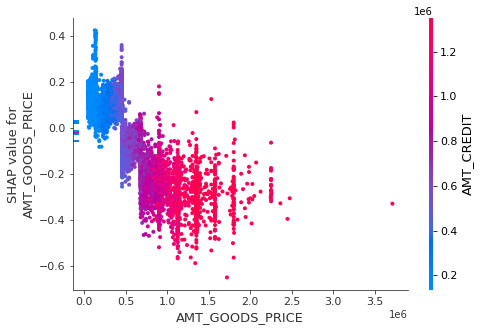

In [76]:
n_observations = 10000

dt_shap = data.iloc[0:n_observations]
dt_shap = dt_shap[cols_pred]
shap.dependence_plot('AMT_GOODS_PRICE', shap_values[:n_observations], dt_shap, interaction_index = 'AMT_CREDIT')